In [1]:
import pandas as pd
df = pd.read_csv('sales_overtime.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939 entries, 0 to 2938
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_mvt        2939 non-null   object 
 1   nb_sales        2939 non-null   int64  
 2   total_revenues  2939 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 69.0+ KB


In [3]:
df.drop(df.tail(1).index,inplace=True) # get rid of the month of june that only contains 1st of June

In [4]:
df['date_mvt'] = pd.to_datetime(df['date_mvt'],format='%Y-%m-%d %H:%M:%S.%f UTC') # format date column to datetime

In [5]:
df2 = df.groupby(pd.Grouper(key='date_mvt', axis=0,  freq='M')).sum() # group by month on date column

In [6]:
df2.reset_index(inplace=True) # get months out of index column back into df
df2.head()

,date_mvt,nb_sales,total_revenues
0,2014-09-30,12,259.010000
1,2014-10-31,13501,270723.840000
2,2014-11-30,4287,146798.120000
3,2014-12-31,4549,146595.658571
4,2015-01-31,4434,129396.430000


In [7]:
df2.drop(df.head(2).index,inplace=True) # get rid of the first 2 months because outliers compared to rest of data

In [8]:
import plotly.express as px
fig = px.line(df2,x='date_mvt',y='total_revenues')      # plot the total monthly revenue of the company overtime 
fig


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [9]:
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

from statsmodels.tsa.seasonal import seasonal_decompose


import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [10]:
df3 = df2.drop('nb_sales',axis=1) # prepare df for times series predictions

In [11]:
df3.columns = ['ds', 'y'] # prepare df for times series predictions

In [12]:
# get the df into two train and test sets
train = df3.iloc[:105]
test = df3.iloc[105:]

train.shape, test.shape

((105, 2), (10, 2))

In [13]:
# set the index for the function seasonal_decompose to work

df3.set_index("ds", inplace = True)

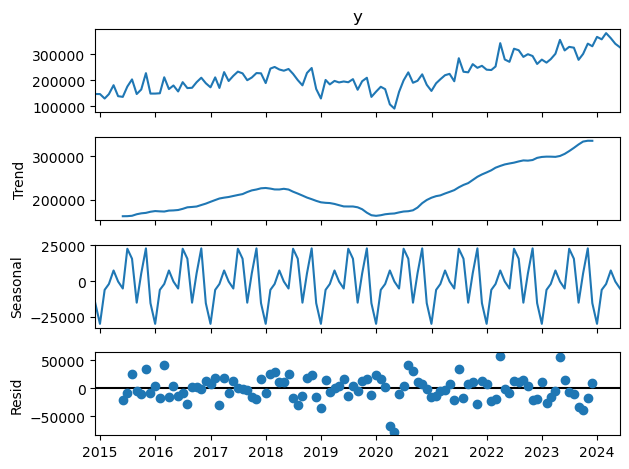

In [14]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df3['y'], model='additive')
result_add.plot();

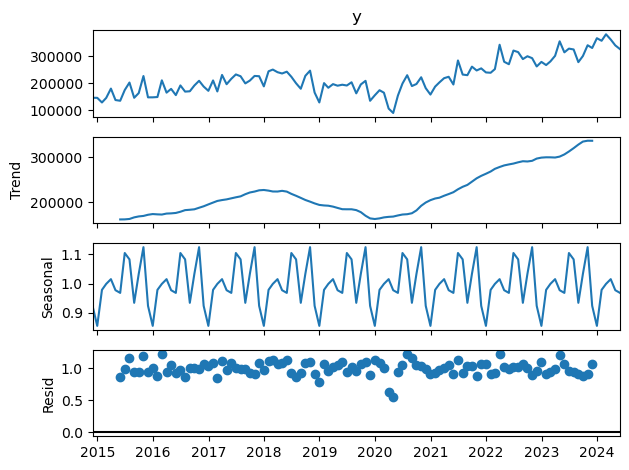

In [15]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df3['y'], model='multiplicative')
result_mul.plot();

In [16]:
# Create a multiplicative model

model = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
model.fit(train)

17:22:28 - cmdstanpy - INFO - Chain [1] start processing
17:22:28 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
horizon = 36      # number of data points we want to forecast in the future (starting from the end of TRAIN)

future = model.make_future_dataframe(periods=horizon, freq='M') # create first column for forecast dataframe

In [18]:
forecast = model.predict(future) # create forcast dataframe using prediction from the model fitted on train

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
136,2026-03-31,413976.343766,357018.259623,472558.652614
137,2026-04-30,399423.606941,341336.954974,456414.726332
138,2026-05-31,393253.634661,333611.894702,451798.361748
139,2026-06-30,448112.811498,387411.659916,505450.798392
140,2026-07-31,437615.754727,374988.008622,497609.788139


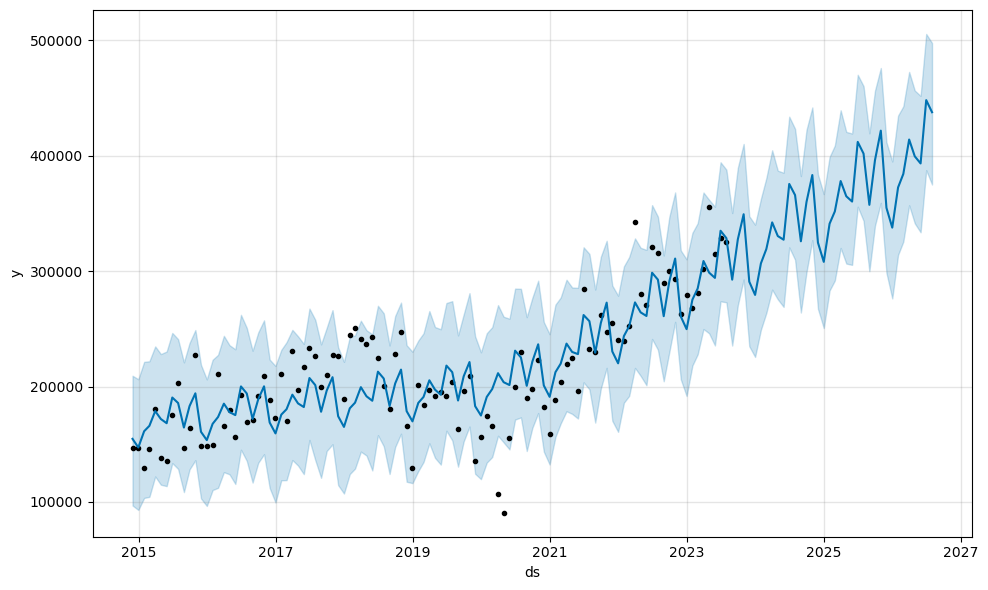

In [19]:
ax = model.plot(forecast) # visualize forecast with trend and lower&upper windows

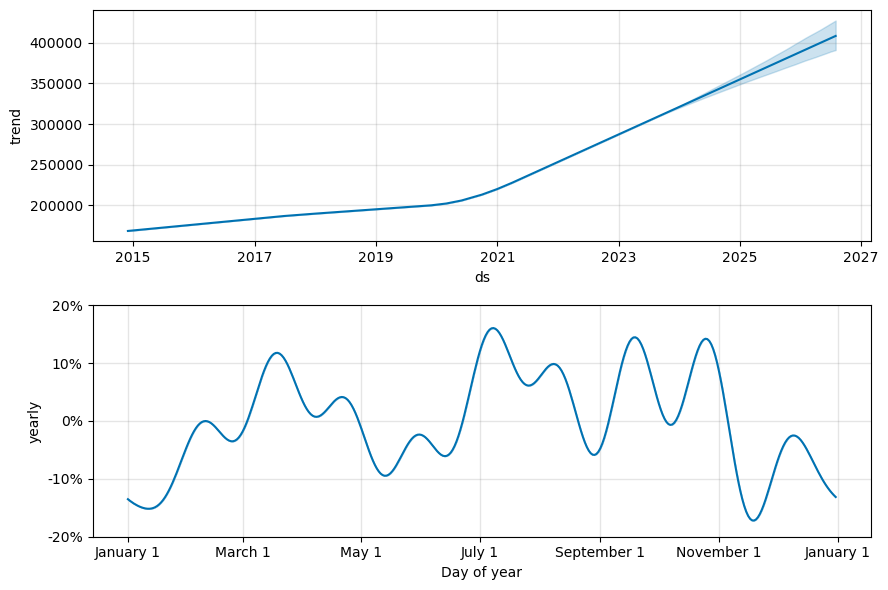

In [20]:
model.plot_components(forecast);

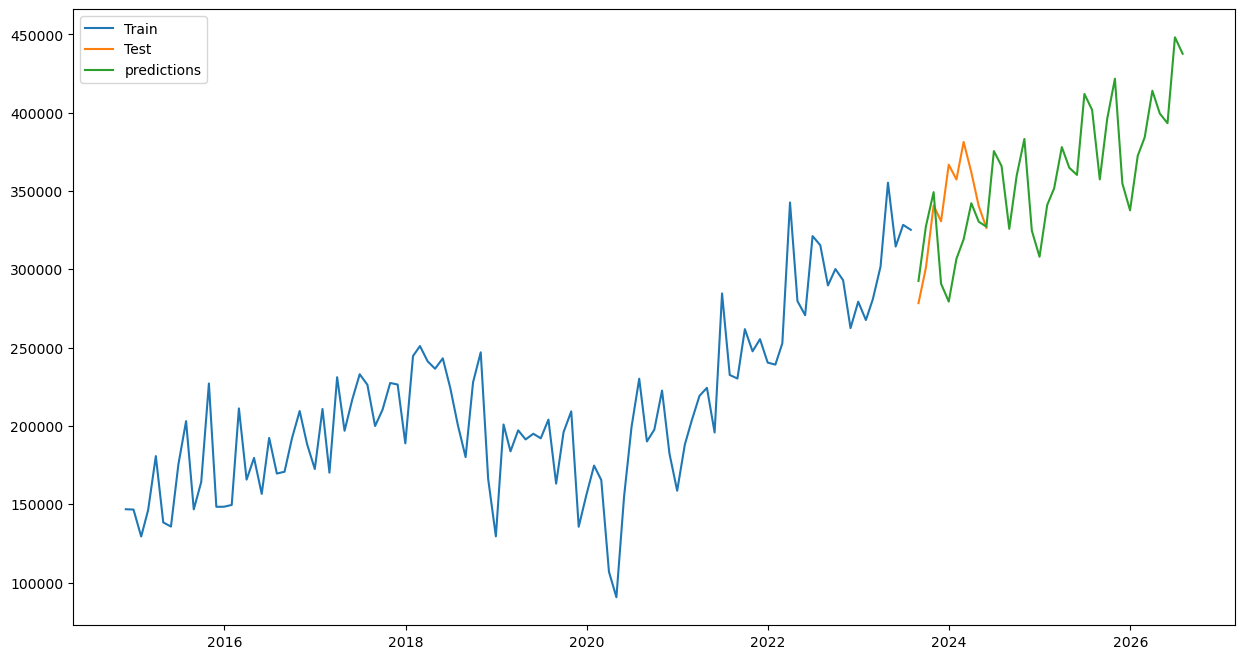

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [22]:
# modify model to include exception over covid time
# create df for lockdowns periods
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-17', 'lower_window': 0, 'ds_upper': '2020-06-02'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-30', 'lower_window': 0, 'ds_upper': '2020-12-15'},
    {'holiday': 'lockdown_3', 'ds': '2021-04-03', 'lower_window': 0, 'ds_upper': '2021-05-19'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-17,0,2020-06-02,77
1,lockdown_2,2020-10-30,0,2020-12-15,46
2,lockdown_3,2021-04-03,0,2021-05-19,46


In [23]:
model2 = Prophet(holidays=lockdowns,seasonality_mode='multiplicative', interval_width=0.95) 
model2 = model2.fit(train)
future2 = model2.make_future_dataframe(periods=horizon, freq='M')
forecast2 = model2.predict(future2)

17:23:03 - cmdstanpy - INFO - Chain [1] start processing
17:23:03 - cmdstanpy - INFO - Chain [1] done processing


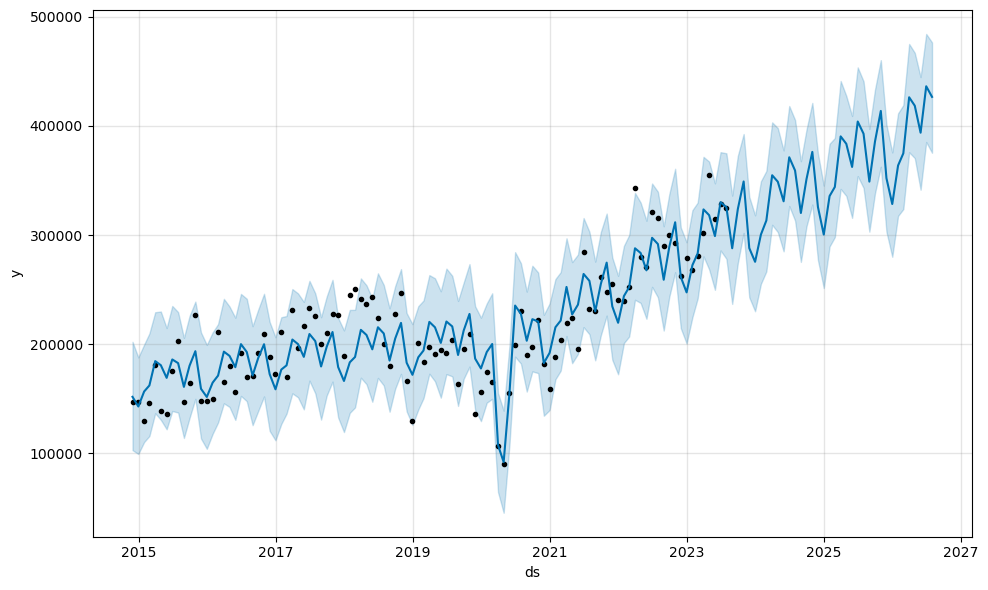

In [24]:
ax2 = model2.plot(forecast2)

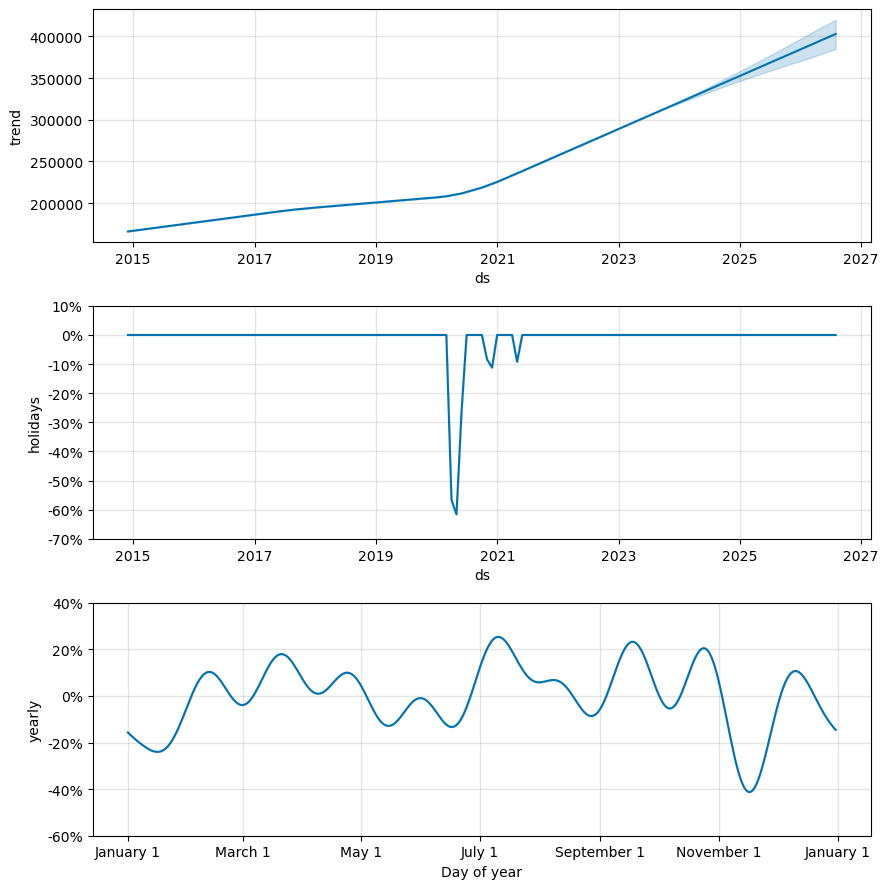

In [25]:
model2.plot_components(forecast2);

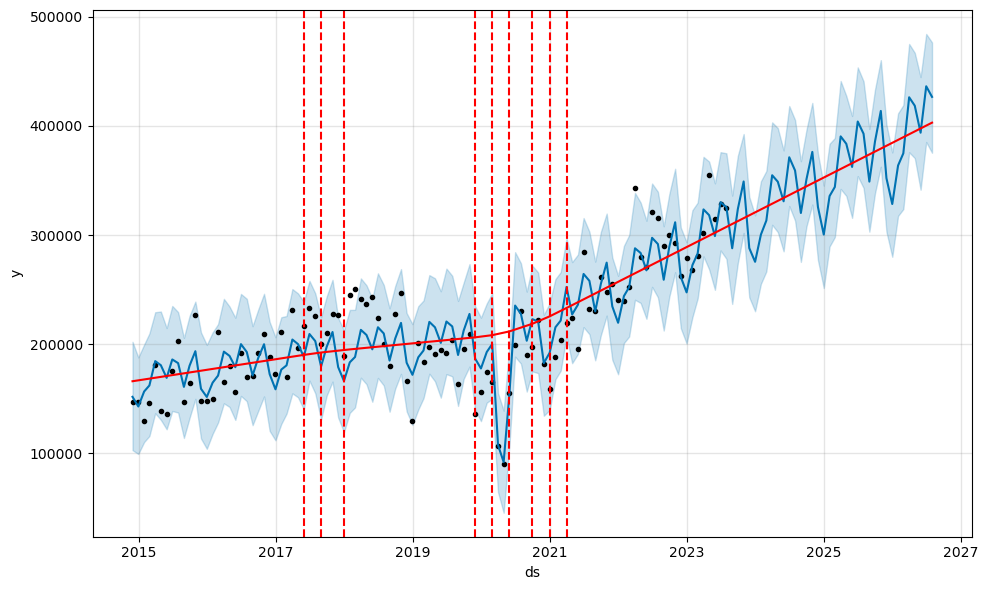

In [26]:
from prophet.plot import add_changepoints_to_plot
fig = model2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), model2, forecast2)

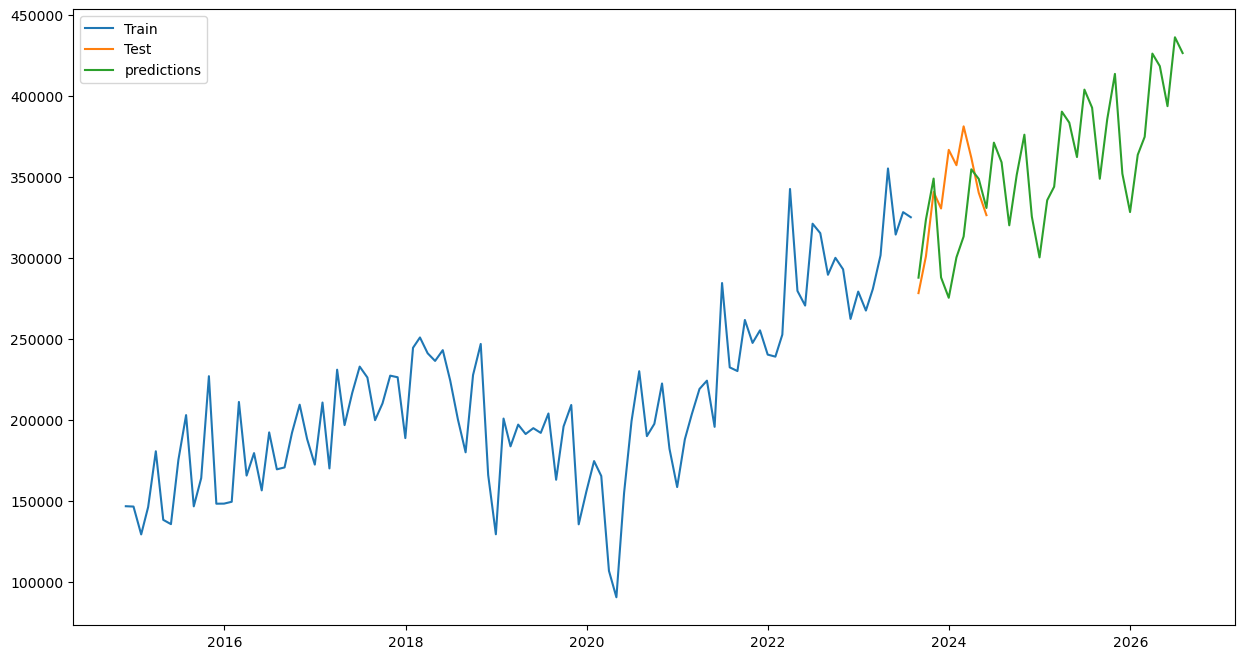

In [30]:
plt.figure(figsize=(15, 8))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()